# Deep learning lab - DSA 
By: _Benjamin Akera_  &  _Andreas Damianou_     
25 July 2020 

In this tutorial we will introduce the concept of deep learning by starting from the fundamentals block, which is a logistic regression model. We will implement this model from scratch to understand its behaviour, and then add more layers to obtain a deep model. 

We will then show how complicated architectures and optimization can be achieved with `keras`, which abstracts all the low-level functionalities.

We will focus on image problems with convolutional neural networks, and explain how transfer learning can help us achieve good results. 

### First import necessary helper libraries for this tutorial and define helper functions

In [ ]:
### Download the data for future use

!wget "http://ec2-3-135-230-66.us-east-2.compute.amazonaws.com/dsa/train.zip"
!unzip 'train.zip'

--2020-07-23 19:47:59--  http://ec2-3-135-230-66.us-east-2.compute.amazonaws.com/dsa/train.zip
Resolving ec2-3-135-230-66.us-east-2.compute.amazonaws.com (ec2-3-135-230-66.us-east-2.compute.amazonaws.com)... 3.135.230.66
Connecting to ec2-3-135-230-66.us-east-2.compute.amazonaws.com (ec2-3-135-230-66.us-east-2.compute.amazonaws.com)|3.135.230.66|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 814615952 (777M) [application/zip]
Saving to: ‘train.zip.1’

train.zip.1         100%[===================>] 776.88M  12.4MB/s    in 61s     

2020-07-23 19:49:00 (12.7 MB/s) - ‘train.zip.1’ saved [814615952/814615952]

Archive:  train.zip
replace train/cgm/train-cgm-738.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow' 

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define helper functions for later

def plot_point(func, t, xmin, xmax):
    N = 10
    x = np.zeros((N,1))+t
    x = x[:,0]
    y = np.linspace(0,func(t),N)
    plt.plot(x,y, 'k--', linewidth=1)
    
    x = np.linspace(xmin, t, N)
    y = np.zeros((N,1))+func(t)
    plt.plot(x,y, 'k--', linewidth=1)

### Define the activation function and its derivative

A deep learning model is, losely speaking, a hierarchy of dot products (involving weight parameters) passed through activations (non-linearities):
$$f(x; w) = activation(w x) $$

This gives us a function the shape of which changes as we change the weights. We want to find a good setting of the weights such that our function $f$ "fits" our observed data well. To find the weights we first define a loss function which we then minimize by computing its gradients with respect to the weights. 

To get started, let's fist define and plot an activation and its derivative.

In [ ]:
# Sigmoid activation function
def activation(x):
    return 1/(1+np.exp(-x))

# Derivative of activation wrt input x
def activation_derivative(x):
    # the activation of the sigmoid function conveniently can be written in terms of its outputs.
    f = activation(x)
    return f*(1-f)

# Derivative of activation wrt input x but expressed when activation(x) is given as argument instead of x
def activation_derivative_f(f):
    return f*(1-f)


### Plots to explore the activation

First, plot the activation for input domain between -10 and 10

Text(0, 0.5, 'activation(x)')

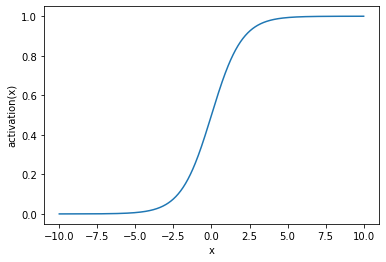

In [ ]:
x1 = np.linspace(-10, 10, 500)
plt.plot(x1, activation(x1))
plt.xlabel('x'); plt.ylabel('activation(x)')

Let's see what happens with low, intermediate and high values:

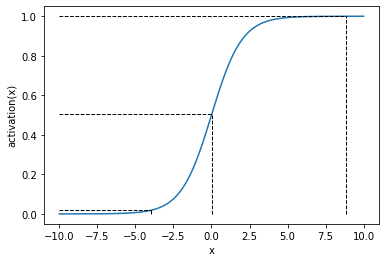

In [ ]:
x1 = np.linspace(-10, 10, 500)
plt.plot(x1, activation(x1))
plt.xlabel('x'); plt.ylabel('activation(x)')
plot_point(activation, x1[150], -10, 10)
plot_point(activation, x1[250], -10, 10)
plot_point(activation, x1[470], -10, 10)

Repeat but for the space -20 to 20

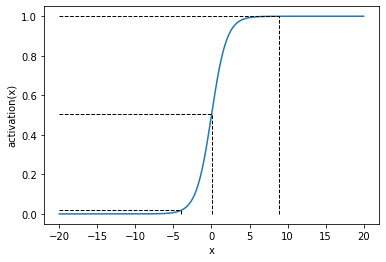

In [ ]:
x2 = np.linspace(-20, 20, 500)
plt.plot(x2, activation(x2))
plt.xlabel('x'); plt.ylabel('activation(x)')
plot_point(activation, x1[150], -20, 20)
plot_point(activation, x1[250], -20, 20)
plot_point(activation, x1[470], -20, 20)

Explore the derivative

Text(0, 0.5, 'activation(x)')

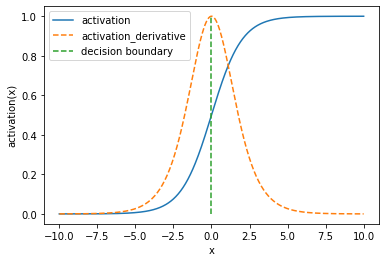

In [ ]:
plt.plot(x1, activation(x1))
plt.plot(x1, 4*activation_derivative(x1), '--')
plt.plot(np.zeros((5,1)), np.linspace(0,1,5), '--')
plt.legend(['activation','activation_derivative','decision boundary'])
plt.xlabel('x')
plt.ylabel('activation(x)')

Now that we understand how the activation function works (which provides the non-linearity in our network), let's use it inside a single-layer model. The model provides the necessary loss function which we use to obtain a fit to the data. 

## Single layer

Let's create some data to start with. We will use $X$ and $y$ to denote inputs and outputs respectively. In general inputs could be images and outputs labels (classification task); or inputs could be time of the year and outputs could be temperature (regression task). But here we will only create very simple toy data:



In [ ]:
# Create some toy data
X = np.array([[0,0,1],
              [0,1,1],
              [1,0,1],
              [1,1,1]])

# Linear case
y = np.array([[0],
              [0],
              [1],
              [1]])

# Fix the seed
np.random.seed(1)

Now let's create a single-layer model which fits the data. Our model will be composed of two parts. Firstly, the parametric fit function:
$$f(x; w) = activation(wx)$$
and then the loss function:
$$Loss(x;w) = \frac{1}{1} (f(x;w) - y)^2$$
The loss function simply says that the further away I predict $f(x;w)$ from the true $y$ corresponding to $x$, the biggest the loss should be. The free parameter here (since my data $x,y$ is fixed) is the weights $w$. So I minimize the loss with respect to $w$ using gradient descent. We take small gradient towards the direction that minimizes the loss. 

For each step, we do a forward pass, meaning computing the value of $f(x;w)$ for the current setting of $w$, and a backward pass, meaning we use gradients to compute the changes we need to do in $w$ for the loss to be smaller. 

Text(0, 0.5, 'error in training data')

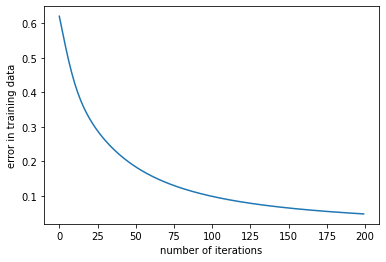

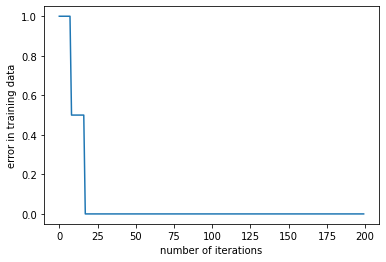

In [ ]:
# Initialize weight
W0 = 2*np.random.random((3,1)) - 1
error = []
error_of_rounded = []
fs = []

# Optimize for 2000 iterations
for i in range(200):
    # FORWARD PASS: x -> f1 
    f0 = X
    f1 = activation(np.dot(f0, W0))
    loss = (0.5 * (y-f1)**2 ).sum()
    loss_of_rounded = (0.5 * (y-np.round(f1))**2 ).sum()
    
    # BACKWARDS PASS (derivatives of loss wrt W0)
    e1 = y - f1   # Error contribution
    delta_1 = e1 * activation_derivative_f(f1)  # The gradient contribution from activation
    gradient_1 = np.dot(f0.T,delta_1)
    
    learning_rate = 0.2
    
    # Update the weights. This is simply adding the gradient multiplied by a learning rate
    W0 += learning_rate * gradient_1

    # Keep track of error
    error.append(loss)
    error_of_rounded.append(loss_of_rounded)
    fs.append(f1)

plt.plot(error)
plt.xlabel('number of iterations')
plt.ylabel('error in training data')

plt.figure()
plt.plot(error_of_rounded)
plt.xlabel('number of iterations')
plt.ylabel('error in training data')

## Deep neural network

We will repeat exactly the same procedure, only now our model will comprise of more than one layers. That is, instead of calling $f(x;w)$ our output for input $x$, we will feed this to another parametric function first: $f_1(f_0(x;w_0);w_0)$. Since we have two sets of weights (for two functions), we have used subscripts. We can consider $f_1$ to be our final function, it just so happens to be a function which is defined by another function. 

We coud have defined an equivalent function $f_{0,1}(x; w_{0,1})$ directly, instead of decomposing it into two functions. However, the key intuition behind deep learning is that decomosability allows us to create __complicated and at the same time learnable functions__.

Create some toy data again:

In [ ]:
X = np.array([[0,0,1],
              [0,1,1],
              [1,0,1],
              [1,1,1]])

# NON-linear case
y = np.array([[0],
               [1],
               [1],
               [0]])

Define parameters and initialize them.

In [ ]:
# Fix the seed
np.random.seed(1)

# randomly initialize our weights with mean 0
W0 = 2*np.random.random((3,4)) - 1
W1 = 2*np.random.random((4,1)) - 1


Optimize!

In [ ]:
error = []
error_of_rounded = []

# Optimize
for i in range(1000):
    # FORWARD PASS: x -> f1 -> f2
    f0 = X
    f1 = activation(np.dot(f0, W0))
    f2 = activation(np.dot(f1, W1))
    # Normally we'd use the cross-entropy loss, but here we'll use sq. error to make derivatives easier.
    loss = (0.5 * (y-f2)**2 ).sum()
    loss_of_rounded = (0.5 * (y-np.round(f2))**2 ).sum()
    
    # BACKWARDS PASS
    e2 = y - f2
    delta_2 = e2 * activation_derivative_f(f2)

    e1 = np.dot(delta_2, W1.T)
    delta_1 = e1 * activation_derivative_f(f1)

    gradient_0 = f0.T.dot(delta_1)
    gradient_1 = f1.T.dot(delta_2)
        
    # Update the weights
    learning_rate = 0.8
    W0 += learning_rate * gradient_0
    W1 += learning_rate * gradient_1

    # Keep track of error
    error.append(loss)
    error_of_rounded.append(loss_of_rounded)

Plot the error per iteration of the optimization.

Text(0, 0.5, 'error in training data')

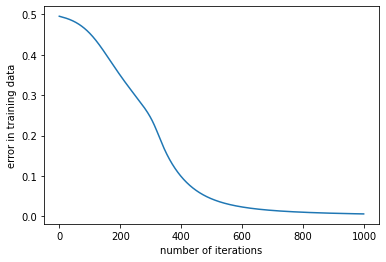

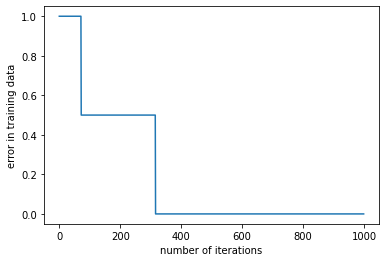

In [ ]:
plt.plot(error)
plt.xlabel('number of iterations')
plt.ylabel('error in training data')

plt.figure()
plt.plot(error_of_rounded)
plt.xlabel('number of iterations')
plt.ylabel('error in training data')

### With Automatic differentiation
For complicated models (eg. too many layers), it is tedious to compute all the gradients by hand. This is where automatic differentiation kicks in. It allows us to write code without having to worry about computing derivatives. 

In tensorflow, the way this is done is by defining our function as usual, but now we have to (a) declare which ones are the variables (the ones we wish to take derivatives for) (b) use tensorflow functions instead of pure numpy, so that the computation graph can be created. The computation graph is then used to compute derivatives using the chain rule automatically.

In [ ]:
import tensorflow as tf
W0 = tf.Variable(2*tf.random.normal((3,4)) - 1, name="W0")
W1 = tf.Variable(2*tf.random.normal((4,1)) - 1, name="W1")

def activation_tf(x):
    return 1/(1+tf.exp(-x))

def fwd(X, W0, W1):
    f1 = activation_tf(X @ W0)
    f2 = activation_tf(f1 @ W1)
    loss = tf.reduce_sum(0.5 * (y-f2)**2 )
    return loss

with tf.GradientTape() as tape:
    loss = fwd(X, W0, W1) 

[g0_autograd, g1_autograd] = tape.gradient(loss, [W0, W1])


To convince ourselves taht this is the right thing to do, let's compute the derivatives manually, as we did before, and then compare them with the ones from autograd:

In [ ]:
W0_ = W0.numpy().copy()
W1_ = W1.numpy().copy()


f1 = activation(np.dot(X, W0_))
f2 = activation(np.dot(f1, W1_))
    
e2 = y - f2
delta_2 = e2 * activation_derivative_f(f2)

e1 = np.dot(delta_2, W1_.T)
delta_1 = e1 * activation_derivative_f(f1)

gradient_0 = -f0.T.dot(delta_1)
gradient_1 = -f1.T.dot(delta_2)

In [ ]:
print(np.abs(g0_autograd.numpy() - gradient_0))
print(np.abs(g1_autograd.numpy() - gradient_1))


[[2.34319123e-10 2.75023346e-11 2.19105221e-09 7.57989102e-10]
 [6.43594109e-10 5.70448309e-11 9.04387509e-09 2.49168377e-09]
 [3.21538463e-09 1.77274652e-10 4.73892290e-09 1.80693532e-09]]
[[3.45708899e-10]
 [7.26416851e-09]
 [3.33499309e-09]
 [8.39829751e-11]]


__Exercises__
1. _[Medium]_ Embed the automatic differentiation loop inside the optimization loop, in order to minimize the loss.  
2. _[Medium]_ Experiment with different settings for the learning rate, including a schedule which starts with bigger and then gradually reduces the learning rate. 
3. _[Hard]_ Experiment with deeper architectures, including different activation functions. 

## Deep Learning with Keras

Being equipped with automatic differentiation, we can now define easily new, complicated loss functions and layers, and compose them in arbitrary ways as long as the chain rule applies. 

Many deep learning frameworks are built on this idea, and extend it with high-level APIs that allow us to easily create and compose layers and losses. Here we will use `Keras` which creates an API on top of Tensorflow. 


There are two ways to build Keras models: **sequential** and **functional**.

The sequential API allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

Alternatively, the **functional API**  allows you to create models that have a lot more flexibility as you can easily define models where layers connect to more than just the previous and next layers. In fact, you can connect layers to (literally) any other layer. As a result, creating complex networks such as siamese networks and residual networks become possible.

[Documentation](https://keras.io/getting-started/sequential-model-guide/)

[Sequential Vs Functional](https://jovianlin.io/keras-models-sequential-vs-functional/)

#### Steps Involved

1.   Start with Input node
2.   Add layers (conv, Pooling, Dense, flatten etc)
3. Compile Model (Loss function, optimizer, metrics)
4. Fit Model (Means to train the model)


In [ ]:
import keras
from keras_preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, Activation, Input, ZeroPadding2D, AveragePooling2D
from keras.optimizers  import RMSprop, SGD, Adam
from keras.losses import sparse_categorical_crossentropy
from keras import models
import cv2

Using TensorFlow backend.


The data is from: https://arxiv.org/pdf/1908.02900.pdf originally hosted at: https://www.kaggle.com/c/cassava-disease/data?select=train.zip . We have already downloaded them from a mirror, in the beginning of this notebook.

In [ ]:
DATA_DIR = 'train/'
IMG_SIZE = (200, 200)
BATCH_SIZE = 300

In [ ]:
import glob 

def get_class(class_name, label_name, data, labels, max_files=-1):
    files = []
    files.extend(glob.glob(DATA_DIR  + class_name + os.path.sep +  '*.jpg'))
    data.extend([cv2.imread(file) for file in files][0:max_files])
    labels.extend([label_name for file in files][0:max_files])

data = []
labels = []

n_images = 400
# classes = ['cbb', 'cmd', 'healthy']
classes = ['cbb', 'healthy']
for i in range(len(classes)):
    get_class(classes[i], i, data, labels, n_images)    


In [ ]:
data = np.array([cv2.resize(d, IMG_SIZE, interpolation = cv2.INTER_AREA) for d in data])
labels = keras.utils.to_categorical(np.array(labels))

In [ ]:
# Shuffle data because labels are in order 
np.random.seed(1)
perm = np.random.permutation(data.shape[0])
data = data[perm]
labels = labels[perm]

Let's plot the first image to see what our data look like:

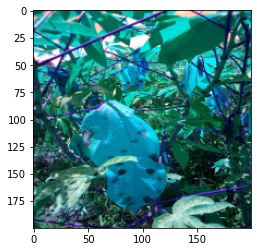

In [ ]:
plt.imshow(data[0])

Now we will build a deep learning model. Let's build a model that contains a convolutional layer, followed by a batch-norm layer, relu activation and then max-pooling. Let's actually do that sequence multiple times to obtain a deep model. For convenience, let's build a function that executes this sequence: 

In [ ]:
def conv_bn_relu(layer, filters=32, kernel_size=(5,5), double_conv=False):
    layer = Conv2D(filters, kernel_size)(layer)
    if double_conv:
        layer = Conv2D(filters, kernel_size)(layer)
    layer = BatchNormalization(axis = 3)(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D((2, 2))(layer)
    return layer

Now we can define the inputs and outputs, and call the aforementioned function multiple times to build our deep model. 

In [ ]:
tf.random.set_seed(0)
np.random.seed(0)

In [ ]:
X_input = Input((*IMG_SIZE, 3))
    
# Zero-Padding: pads the border of X_input with zeroes
X = ZeroPadding2D((3, 3))(X_input)

X = conv_bn_relu(X, filters=32, kernel_size=(7,7), double_conv=True)
X = conv_bn_relu(X, filters=32, kernel_size=(5,5), double_conv=True)
X = conv_bn_relu(X, filters=64, kernel_size=(5,5), double_conv=True)
X = conv_bn_relu(X, filters=128, kernel_size=(3,3), double_conv=True)
X = conv_bn_relu(X, filters=256, kernel_size=(3,3), double_conv=True)

# FLATTEN X (means convert it to a vector) + FULLYCONNECTED
X = Flatten()(X)
X = Dense(64, activation="relu")(X)
X = Dropout(0.2)(X)
X = Dense(labels.shape[1], activation='softmax')(X)

# Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
model = keras.models.Model(inputs = X_input, outputs = X)

In [ ]:
model.compile(loss='binary_crossentropy', # 'categorical_crossentropy' if >2 classes
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 206, 206, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 200, 200, 32)      4736      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 194, 194, 32)      50208     
_________________________________________________________________
batch_normalization_1 (Batch (None, 194, 194, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 194, 194, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 97, 97, 32)        0   

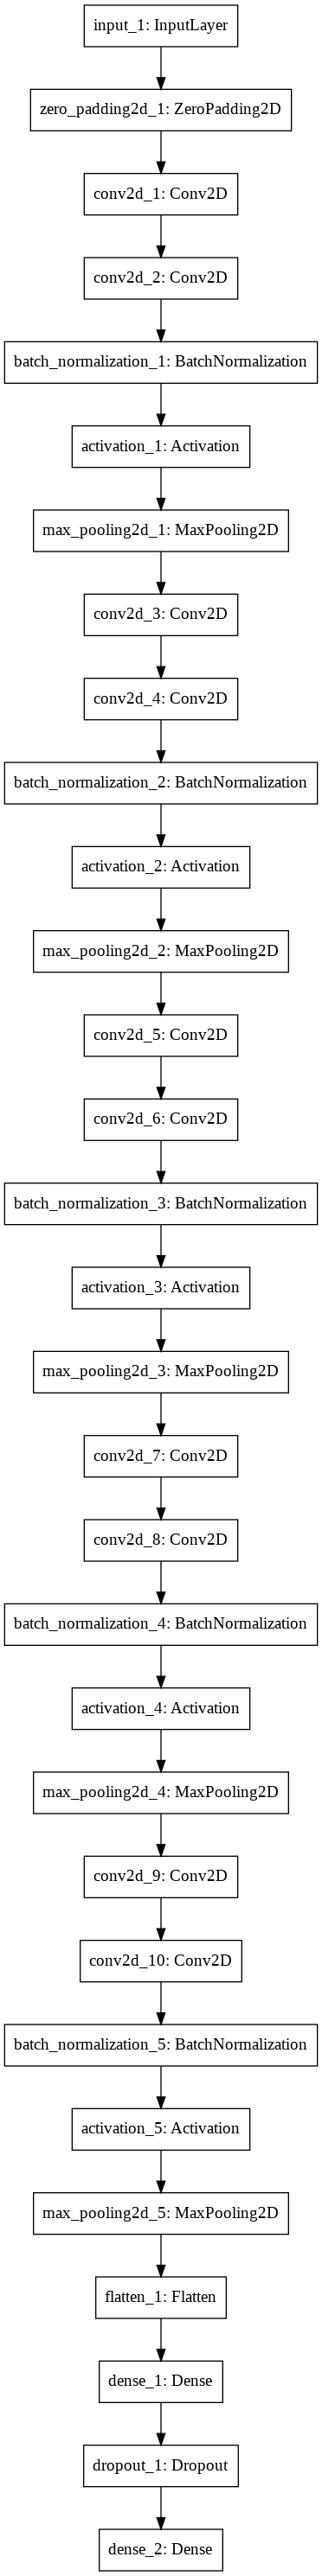

In [ ]:
keras.utils.plot_model(model)

Train the model! *Warning:* This takes a bit of time. You can reduce the number of epochs or training set for a quick run, but keep in mind that this will harm accuracy.

In [ ]:
history = model.fit(x=data, y=labels, batch_size=BATCH_SIZE, epochs=20, validation_split = 0.2, shuffle=True)

Train on 572 samples, validate on 144 samples
Epoch 1/20
572/572 [==============================] - 39s 68ms/step - loss: 1.1840 - accuracy: 0.5262 - val_loss: 8.2011 - val_accuracy: 0.4653
Epoch 2/20
572/572 [==============================] - 4s 7ms/step - loss: 0.9561 - accuracy: 0.5017 - val_loss: 7.1360 - val_accuracy: 0.5347
Epoch 3/20
572/572 [==============================] - 4s 6ms/step - loss: 0.6099 - accuracy: 0.6119 - val_loss: 7.1360 - val_accuracy: 0.5347
Epoch 4/20
572/572 [==============================] - 4s 6ms/step - loss: 0.5579 - accuracy: 0.6731 - val_loss: 7.1360 - val_accuracy: 0.5347
Epoch 5/20
572/572 [==============================] - 4s 6ms/step - loss: 0.5551 - accuracy: 0.6783 - val_loss: 7.1360 - val_accuracy: 0.5347
Epoch 6/20
572/572 [==============================] - 4s 6ms/step - loss: 0.5550 - accuracy: 0.6783 - val_loss: 7.1360 - val_accuracy: 0.5347
Epoch 7/20
572/572 [==============================] - 4s 6ms/step - loss: 0.5498 - accuracy: 0.6643 

### Observations from training
The training outcome depends on the random initialization and architecture that you pick. 

But we generally see that the performance is not great. The network is learning something, but you might notice tht it is quite unstable (different runs produce different results, based on initialization) and the validation error does not behave as expected. We migth also observe that the performance on validation data doesn't match the one of the training data, a possible sign of overfitting. 

Realistically, we would need:
- More data  
- Train for longer  
- Consider a more elaborate architecture.  

Instead, below we show another alternative: transfer learning. It allows us to leverage a model which is already treained on a different (but related) task so as to learn better in the current task.

__Exercises__ 
Try to experiment a little bit with the "training from scratch" code that was given above. In addition to the aforementioned suggestions for better training you can try to: 
1. _[Easy]_ Play with the choice of dropout vs no dropout or a different regularization, and also change the dropout probability. 
2. _[Easy]_ Experiment with including vs not including a batch-norm layer.
3. _[Medium]_ Try defining a different architecture. 
4. _[Hard]_ Plot together the training and validation loss (y-axis) with the number of epochs on the x-axis. 

## Reusing deep neural networks

Transfer learning is a machine learning technique where a model trained on one task is re-purposed on a second related task.

It is common to perform transfer learning with predictive modeling problems that use image data as input.

This may be a prediction task that takes photographs or video data as input.

For these types of problems, it is common to use a deep learning model pre-trained for a large and challenging image classification task such as the ImageNet 1000-class photograph classification competition.

The research organizations that develop models for this competition and do well often release their final model under a permissive license for reuse. These models can take days or weeks to train on modern hardware.

These models can be downloaded and incorporated directly into new models that expect image data as input.


 [More info](https://machinelearningmastery.com/transfer-learning-for-deep-learning/)
 
 
 ![alt text](https://cdn-images-1.medium.com/max/1600/1*9GTEzcO8KxxrfutmtsPs3Q.png)

When we perform transfer learning, we use the following terminology:
- **Source task** is the task we have already trained a model, called the **source model** or the **pre-trained model**. We assume we have solved this task well because we have an abundance of training data (the **source data**) and expertise to train the model.
- **Target task** is the task we want to perform predictions on, but we can't train a model from scratch either because we have insufficient training data (i.e. **target data**) or because we're lacking epertise.

We want to transfer knowledge from the source model to a target model. There are two dominant ways to perform transfer learning:  
- Use the source model as feature extractor. For example forward propagated images of the target task into the source model, and use the top layers as features for a new, data-efficient classifier (such as a Gaussian process).
- Fine-tune the source model by adding/dropping layers and freezing the existing layers that are learning generic, transferrable features. 

These two cases are demonstrated below:

In [ ]:
from IPython.display import HTML
HTML('<img src="http://adamian.github.io/var/xfer_metamodel.gif", width="50%" height=50%>')

In [ ]:
HTML('<img src="http://adamian.github.io/var/xfer_modelhandler.gif", width="50%" height=50%>')

Here we focus on the later case, i.e. fine-tuning. We will fine-tune the VGG-16 neural network which has been trained on the very large ImageNet databse.

### VGG 

![alt text](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [ ]:
from keras.applications import VGG16

In [ ]:
# Use imagenet weights
vgg_conv = VGG16(weights='imagenet',
                include_top = False, 
                input_shape = ((*IMG_SIZE,3)))

In [ ]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [ ]:
### Add our custom layers

tr_model = vgg_conv.output
tr_model = Flatten()(tr_model)
tr_model = Dense(64, activation='relu')(tr_model)
tr_model = Dropout(0.5)(tr_model)
tr_model = Dense(labels.shape[1], activation='softmax')(tr_model)

In [ ]:
new_model = models.Model(inputs=vgg_conv.input, outputs=tr_model)

### Freezing and Fine-tuning vgg16

![alt text](https://blog.keras.io/img/imgclf/vgg16_modified.png)

(Image: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)

In [ ]:
def print_layer_trainable():
    for layer in new_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
for i, layer in enumerate(new_model.layers):
    print(i, layer.name)

0 input_2
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_2
20 dense_3
21 dropout_2
22 dense_4


In [ ]:
for layer in new_model.layers[:18]:
    layer.trainable = False
for layer in new_model.layers[18:]:
    layer.trainable = True

In [ ]:
print_layer_trainable()

False:	input_2
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
True:	block5_pool
True:	flatten_2
True:	dense_3
True:	dropout_2
True:	dense_4


In [ ]:
new_model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [ ]:
# history = new_model.fit_generator(
#         train_generator,
#         steps_per_epoch=2000 // batch_size,
#         epochs=10,
#         validation_data=validation_generator,
#         validation_steps=800 // batch_size)

Warning! This will take time! 

In [ ]:
history = new_model.fit(x=data, y=labels ,batch_size=BATCH_SIZE, epochs=5, validation_split = 0.2, shuffle=True)

Train on 572 samples, validate on 144 samples
Epoch 1/5
572/572 [==============================] - 35s 61ms/step - loss: 29.6630 - accuracy: 0.5192 - val_loss: 13.3621 - val_accuracy: 0.4653
Epoch 2/5
572/572 [==============================] - 3s 5ms/step - loss: 6.6645 - accuracy: 0.5962 - val_loss: 0.5325 - val_accuracy: 0.7986
Epoch 3/5
572/572 [==============================] - 3s 5ms/step - loss: 0.4170 - accuracy: 0.7955 - val_loss: 0.4768 - val_accuracy: 0.7500
Epoch 4/5
572/572 [==============================] - 3s 5ms/step - loss: 0.3148 - accuracy: 0.8112 - val_loss: 0.4729 - val_accuracy: 0.7708
Epoch 5/5
572/572 [==============================] - 3s 5ms/step - loss: 0.2738 - accuracy: 0.8392 - val_loss: 0.4696 - val_accuracy: 0.7847


Even though we only did fewer epochs the accuracy is already much better compared to learning from scratch!

For convenience, we can save the model and load it later, as shown below:

In [ ]:
new_model.save('transfer_model.h5')

In [ ]:
from keras.models import load_model
new_model = load_model('transfer_model.h5')

__Exercises__ 
1. __[Easy]__ Perform transfer learning by changing the structure of the `new_model` to something of your choice. 
2. __[Hard]__ Try to make the network overfit by training for many more epochs. Show the overfitting pattern by plotting the training together with the validation loss curves (y-axis) versus the epoch number (x-axis). 
3. __[Medium]__ Check the keras documentation to figure out how to do predictions (hint: use the `.predict` function). Keep a few extra images for a test set and see how well your network predicts on those. 
4. __[Hard]__ Perform transfer learning with the 'feature extraction' method. You would need to extract features from a specific layer (after feeding your test inputs to the model), and use these features as the new "inputs" to a classifier of your choice, e.g. an SVM from sklearn. _Hint_: One way to extract features from layer `i` from the bottom is: 
```
feature_model = Model(new_model.inputs, outputs=new_model.layers[-i].output) # Dense layer
features = feature_model.predict(target_inputs) 
```
To test this, you can use `target_inputs=data[0:10,:,:,:], target_outputs=labels[0:10,:]` to simulate a target task, but ideally you can use a separate target set. You can now train a sklearn model with `X=features, y = target_outputs`. 